# Redes LSTM

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

import optuna
import optuna.visualization as vis
import mlflow

import os
import nbimporter
from dotenv import load_dotenv

In [81]:
load_dotenv()

True

### Creamos un experimento de MLFLOW

In [82]:
MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI')

In [83]:
def get_or_create_experiment(experiment_name):
    """
    Retrieve the ID of an existing MLflow experiment or create a new one if it doesn't exist.
    """

    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)

In [84]:
experiment_id = get_or_create_experiment("LSTM_1")

### Definimos primeramente algunas funciones preliminares para partición del conjunto de datos y escalamiento de datos.

In [85]:
def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado <-- <--- ¡esta parte de la función se ejecuta en este caso!
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        # Entrada al modelo
        X.append(array[i:i+INPUT_LENGTH,0:cols])

        # Salida (el índice 1 corresponde a la columna con la variable a predecir)
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

def escalar_dataset(data_input, col_ref):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir

    
    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df.columns.get_loc(col_ref)

    # Número de instantes de tiempo de entrada y de covariables
    NFEATS = data_input['x_tr'].shape[2]
    print("NFEATS=",NFEATS)

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]


### Obtenemos los datos y los preparamos

In [86]:
df = pd.read_csv('../data/processed/processed_data_energy.csv')
df.drop(columns = ['hora', 'dia', 'mes', 'anio'], inplace = True)

In [87]:
tr, vl, ts = train_val_test_split(df, tr_size=0.8, vl_size=0.1, ts_size=0.1 )

In [88]:
# Definición de los hiperparámetros INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 12     # Registros de 24 horas consecutivas a la entrada 
OUTPUT_LENGTH = 5    # El modelo va a predecir 4 hora a futuro

# Datasets supervisados para entrenamiento (x_tr, y_tr), validación
# (x_vl, y_vl) y prueba (x_ts, y_ts)
x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

In [89]:
# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'demanda_energia' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

NFEATS= 25


### Tomamos una muestra de datos para la optimización de la red

In [57]:
x_sample = x_tr_s[:10000]
y_sample = y_tr_s[:10000]

In [67]:
x_test_sample = x_vl_s[:1000]
y_test_sample = y_vl_s[:1000]

### Procedemos ahora a construir la red LSTM

In [90]:
# El modelo
N_UNITS = 60 # Tamaño del estado oculto (h) y de la celda de memoria (c)   #  <----- hiperparámetro
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 24 (horas) x 14 (feature)   

In [91]:
run_name = "first_attempt"

In [103]:
def objective(trial):
    # Suggest values for hyperparameters

    modelo = Sequential()

    n_units = trial.suggest_int("lstm_units_L1", 80, 140, log = True)
    modelo.add(LSTM(n_units, input_shape=INPUT_SHAPE))
    modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 0.5, log = True)

    optimizer = Adam(learning_rate = learning_rate)
    metrics = ["mae", "mse", "mape"]
    modelo.compile(optimizer=optimizer, loss="mape", metrics=metrics)
    modelo.fit(x = x_sample, y = y_sample, epochs = 20, validation_split= 0.2, verbose=0 )

    # Make predictions and calculate MAPE
    y_pred = modelo.predict(x_test_sample)
    mape = mean_absolute_percentage_error(y_test_sample.flatten(), y_pred.flatten())

    # Return MAPE
    return mape

In [104]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [105]:
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True):
    # Initialize the Optuna study
    # Create study object
    study = optuna.create_study(direction="minimize")

    # Run optimization process
    study.optimize(objective, n_trials=150, show_progress_bar=True)

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_mape", study.best_value)

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "Energy Demand Prediction",
            "optimizer_engine": "optuna",
            "model_family": "LSTM",
            "feature_set_version": 1,
        }
    )


[I 2024-05-26 15:49:16,728] A new study created in memory with name: no-name-457dfce6-5d37-4dcf-9ad3-663977e9d416


  0%|          | 0/150 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 15:50:02,641] Trial 0 finished with value: 7.012485676002108 and parameters: {'lstm_units_L1': 85, 'learning_rate': 0.0018852815049592783}. Best is trial 0 with value: 7.012485676002108.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 15:50:51,627] Trial 1 finished with value: 14.256819214232344 and parameters: {'lstm_units_L1': 85, 'learning_rate': 0.0002079765516239791}. Best is trial 0 with value: 7.012485676002108.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 15:51:43,456] Trial 2 finished with value: 15.709086761425084 and parameters: {'lstm_units_L1': 97, 'learning_rate': 5.7689804181693204e-05}. Best is trial 0 with value: 7.012485676002108.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 15:52:55,525] Trial 3 finished with value: 14.183068831731708 and parameters: {'lstm_units_L1': 114, 'learning_rate': 0.0003567682999639838}. Best is trial 0 with value: 7.012485676002108.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 15:54:02,486] Trial 4 finished with value: 15.317215827913554 and parameters: {'lstm_units_L1': 90, 'learning_rate': 1.1684964377155622e-05}. Best is trial 0 with value: 7.012485676002108.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 15:54:48,843] Trial 5 finished with value: 10.920362876477917 and parameters: {'lstm_units_L1': 96, 'learning_rate': 0.00100001818413489}. Best is trial 0 with value: 7.012485676002108.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[I 2024-05-26 15:55:47,678] Trial 6 finished with value: 11.413388488199452 and parameters: {'lstm_units_L1': 126, 'learning_rate': 0.0006438817793971845}. Best is trial 0 with value: 7.012485676002108.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 15:57:00,458] Trial 7 finished with value: 310.48393263457183 and parameters: {'lstm_units_L1': 139, 'learning_rate': 0.09869250806458234}. Best is trial 0 with value: 7.012485676002108.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 15:57:59,701] Trial 8 finished with value: 15.114876036091472 and parameters: {'lstm_units_L1': 117, 'learning_rate': 1.114969894161668e-05}. Best is trial 0 with value: 7.012485676002108.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 15:59:10,305] Trial 9 finished with value: 9.05660154236591 and parameters: {'lstm_units_L1': 130, 'learning_rate': 0.002110611922158374}. Best is trial 0 with value: 7.012485676002108.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 16:00:07,784] Trial 10 finished with value: 5.953421842297536 and parameters: {'lstm_units_L1': 80, 'learning_rate': 0.035223989471920646}. Best is trial 10 with value: 5.953421842297536.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 16:01:09,774] Trial 11 finished with value: 6.931248672606183 and parameters: {'lstm_units_L1': 81, 'learning_rate': 0.05519718623769123}. Best is trial 10 with value: 5.953421842297536.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[I 2024-05-26 16:02:10,124] Trial 12 finished with value: 4.4622981579016505 and parameters: {'lstm_units_L1': 80, 'learning_rate': 0.04766564987977953}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 16:03:06,466] Trial 13 finished with value: 6.861893769853444 and parameters: {'lstm_units_L1': 80, 'learning_rate': 0.015440309934744692}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 16:04:09,679] Trial 14 finished with value: 784.1954391737427 and parameters: {'lstm_units_L1': 102, 'learning_rate': 0.48738095957660627}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 16:05:07,245] Trial 15 finished with value: 9.608306140120456 and parameters: {'lstm_units_L1': 92, 'learning_rate': 0.012722848386574753}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 16:06:02,747] Trial 16 finished with value: 9.01885283919094 and parameters: {'lstm_units_L1': 87, 'learning_rate': 0.010010943040367455}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 16:07:07,778] Trial 17 finished with value: 435.0885474763583 and parameters: {'lstm_units_L1': 107, 'learning_rate': 0.4885671747785952}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[I 2024-05-26 16:08:07,103] Trial 18 finished with value: 18.95257505521703 and parameters: {'lstm_units_L1': 83, 'learning_rate': 0.09401342292824343}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 16:09:07,004] Trial 19 finished with value: 22.129961352212913 and parameters: {'lstm_units_L1': 95, 'learning_rate': 0.0396591281359565}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 16:10:09,156] Trial 20 finished with value: 8.568091848114749 and parameters: {'lstm_units_L1': 101, 'learning_rate': 0.009228537547900463}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 16:11:01,299] Trial 21 finished with value: 7.85685650030169 and parameters: {'lstm_units_L1': 82, 'learning_rate': 0.021899309248958655}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 16:11:56,252] Trial 22 finished with value: 8.784205585589927 and parameters: {'lstm_units_L1': 80, 'learning_rate': 0.005099124154737741}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 16:12:54,732] Trial 23 finished with value: 362.73212894559856 and parameters: {'lstm_units_L1': 89, 'learning_rate': 0.265018843370361}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 16:13:54,233] Trial 24 finished with value: 32.75004037071919 and parameters: {'lstm_units_L1': 80, 'learning_rate': 0.14193502182446008}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 16:14:48,991] Trial 25 finished with value: 9.092857988719706 and parameters: {'lstm_units_L1': 86, 'learning_rate': 0.030233752675267938}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
[I 2024-05-26 16:15:30,670] Trial 26 finished with value: 8.80591090020309 and parameters: {'lstm_units_L1': 92, 'learning_rate': 0.005650621863196765}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[I 2024-05-26 16:16:20,914] Trial 27 finished with value: 8.850648288244036 and parameters: {'lstm_units_L1': 84, 'learning_rate': 0.021178088253593377}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 16:17:16,800] Trial 28 finished with value: 7.688216349609794 and parameters: {'lstm_units_L1': 88, 'learning_rate': 0.004538999912162901}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
[I 2024-05-26 16:18:03,108] Trial 29 finished with value: 91.63653509296805 and parameters: {'lstm_units_L1': 84, 'learning_rate': 0.05919251902816901}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[I 2024-05-26 16:19:00,298] Trial 30 finished with value: 325.2520778420957 and parameters: {'lstm_units_L1': 109, 'learning_rate': 0.18788791088467538}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 16:19:55,576] Trial 31 finished with value: 7.790081601366009 and parameters: {'lstm_units_L1': 81, 'learning_rate': 0.051795439412181274}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
[I 2024-05-26 16:20:42,288] Trial 32 finished with value: 25.66180611046396 and parameters: {'lstm_units_L1': 80, 'learning_rate': 0.07398173285052481}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 16:21:31,706] Trial 33 finished with value: 7.81186772446362 and parameters: {'lstm_units_L1': 85, 'learning_rate': 0.015188949393468943}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 16:22:14,756] Trial 34 finished with value: 11.706098034915765 and parameters: {'lstm_units_L1': 83, 'learning_rate': 0.03256332934760403}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 16:23:01,434] Trial 35 finished with value: 15.222605025274156 and parameters: {'lstm_units_L1': 92, 'learning_rate': 9.622360802204526e-05}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 16:24:07,566] Trial 36 finished with value: 165.12830858920714 and parameters: {'lstm_units_L1': 86, 'learning_rate': 0.18943901808594282}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[I 2024-05-26 16:25:15,426] Trial 37 finished with value: 7.1649826301736175 and parameters: {'lstm_units_L1': 82, 'learning_rate': 0.0034676178152512472}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 16:26:31,716] Trial 38 finished with value: 5.528640076785927 and parameters: {'lstm_units_L1': 99, 'learning_rate': 0.019351714618588933}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
[I 2024-05-26 16:27:47,206] Trial 39 finished with value: 9.58706374261178 and parameters: {'lstm_units_L1': 114, 'learning_rate': 0.0008734891218657299}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 16:29:12,399] Trial 40 finished with value: 8.44677590727524 and parameters: {'lstm_units_L1': 121, 'learning_rate': 0.008417180776952016}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 16:30:30,230] Trial 41 finished with value: 10.755763484104238 and parameters: {'lstm_units_L1': 99, 'learning_rate': 0.020391407862798125}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 16:31:40,291] Trial 42 finished with value: 13.413514660519237 and parameters: {'lstm_units_L1': 89, 'learning_rate': 0.04401357268071648}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 16:32:28,925] Trial 43 finished with value: 13.94356550470439 and parameters: {'lstm_units_L1': 94, 'learning_rate': 0.08351833980282118}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 16:33:14,733] Trial 44 finished with value: 9.712783290111165 and parameters: {'lstm_units_L1': 80, 'learning_rate': 0.0014997520289090716}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 16:34:03,279] Trial 45 finished with value: 7.799160783911845 and parameters: {'lstm_units_L1': 85, 'learning_rate': 0.0026773556753292914}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 16:34:52,530] Trial 46 finished with value: 12.951300959342944 and parameters: {'lstm_units_L1': 82, 'learning_rate': 0.0003660944028926526}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 16:35:42,994] Trial 47 finished with value: 6.22845835565911 and parameters: {'lstm_units_L1': 87, 'learning_rate': 0.027675550055183466}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[I 2024-05-26 16:36:35,789] Trial 48 finished with value: 13.944958676995771 and parameters: {'lstm_units_L1': 98, 'learning_rate': 2.4355553256003127e-05}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
[I 2024-05-26 16:37:16,148] Trial 49 finished with value: 9.291449791130097 and parameters: {'lstm_units_L1': 90, 'learning_rate': 0.015516725626793357}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 16:38:14,855] Trial 50 finished with value: 6.565687737452073 and parameters: {'lstm_units_L1': 87, 'learning_rate': 0.008090305127467811}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[I 2024-05-26 16:38:54,771] Trial 51 finished with value: 7.294209783259633 and parameters: {'lstm_units_L1': 87, 'learning_rate': 0.007658154736569197}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 16:39:53,084] Trial 52 finished with value: 5.418772150092121 and parameters: {'lstm_units_L1': 102, 'learning_rate': 0.02887257377095505}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 16:40:45,473] Trial 53 finished with value: 6.62789458437855 and parameters: {'lstm_units_L1': 102, 'learning_rate': 0.02340398430932758}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[I 2024-05-26 16:41:36,879] Trial 54 finished with value: 7.85782959393624 and parameters: {'lstm_units_L1': 104, 'learning_rate': 0.03098929664940085}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 16:42:31,933] Trial 55 finished with value: 62.83787068464811 and parameters: {'lstm_units_L1': 109, 'learning_rate': 0.11811172534069833}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 16:43:13,876] Trial 56 finished with value: 7.653904888485623 and parameters: {'lstm_units_L1': 96, 'learning_rate': 0.012778484092504304}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[I 2024-05-26 16:44:04,983] Trial 57 finished with value: 18.328883406374203 and parameters: {'lstm_units_L1': 100, 'learning_rate': 0.061685887240398085}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[I 2024-05-26 16:44:55,176] Trial 58 finished with value: 7.630988585776073 and parameters: {'lstm_units_L1': 93, 'learning_rate': 0.011086363558859764}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 16:46:09,463] Trial 59 finished with value: 7.14389560791245 and parameters: {'lstm_units_L1': 140, 'learning_rate': 0.006405873391099142}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 16:47:07,377] Trial 60 finished with value: 30.992686749295345 and parameters: {'lstm_units_L1': 106, 'learning_rate': 0.03878055012839818}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[I 2024-05-26 16:48:01,970] Trial 61 finished with value: 6.013321625004059 and parameters: {'lstm_units_L1': 103, 'learning_rate': 0.024462646609634257}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 16:48:53,372] Trial 62 finished with value: 9.984684997481155 and parameters: {'lstm_units_L1': 111, 'learning_rate': 0.02500751839690889}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 16:49:45,486] Trial 63 finished with value: 9.115832396821435 and parameters: {'lstm_units_L1': 103, 'learning_rate': 0.01727714444243262}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[I 2024-05-26 16:50:36,706] Trial 64 finished with value: 17.646141497047267 and parameters: {'lstm_units_L1': 104, 'learning_rate': 0.044174558938979286}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[I 2024-05-26 16:51:26,404] Trial 65 finished with value: 480.7694683949735 and parameters: {'lstm_units_L1': 97, 'learning_rate': 0.29647273186940293}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 16:52:21,210] Trial 66 finished with value: 12.7429129612128 and parameters: {'lstm_units_L1': 91, 'learning_rate': 0.07864741879457071}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 16:53:21,985] Trial 67 finished with value: 9.633047331942528 and parameters: {'lstm_units_L1': 132, 'learning_rate': 0.029626485853484007}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 16:54:15,026] Trial 68 finished with value: 10.458150753368898 and parameters: {'lstm_units_L1': 107, 'learning_rate': 0.003684393809275569}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 16:55:04,364] Trial 69 finished with value: 7.0127113817518225 and parameters: {'lstm_units_L1': 95, 'learning_rate': 0.011359282770965404}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 16:55:54,594] Trial 70 finished with value: 103.7796722201743 and parameters: {'lstm_units_L1': 83, 'learning_rate': 0.14192033204679713}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 16:56:46,949] Trial 71 finished with value: 9.25743189528025 and parameters: {'lstm_units_L1': 101, 'learning_rate': 0.021555193909044194}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 16:57:44,112] Trial 72 finished with value: 14.994238489846751 and parameters: {'lstm_units_L1': 102, 'learning_rate': 0.057884956706910365}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 16:58:40,558] Trial 73 finished with value: 6.787096245269786 and parameters: {'lstm_units_L1': 109, 'learning_rate': 0.031186729590158904}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 16:59:32,237] Trial 74 finished with value: 9.054888812334937 and parameters: {'lstm_units_L1': 99, 'learning_rate': 0.019797592273769305}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:00:23,583] Trial 75 finished with value: 11.936947566615938 and parameters: {'lstm_units_L1': 104, 'learning_rate': 0.008792755788944891}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 17:01:26,662] Trial 76 finished with value: 28.453294340423525 and parameters: {'lstm_units_L1': 112, 'learning_rate': 0.10317428117491065}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[I 2024-05-26 17:02:09,216] Trial 77 finished with value: 9.560693553307619 and parameters: {'lstm_units_L1': 88, 'learning_rate': 0.01464521528311344}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 17:02:40,806] Trial 78 finished with value: 20.573731169119217 and parameters: {'lstm_units_L1': 84, 'learning_rate': 0.042363495144683606}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 17:03:40,921] Trial 79 finished with value: 9.077062783665347 and parameters: {'lstm_units_L1': 117, 'learning_rate': 0.02580254463543393}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:04:29,070] Trial 80 finished with value: 7.985396179774899 and parameters: {'lstm_units_L1': 81, 'learning_rate': 0.00662561816844735}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:05:13,554] Trial 81 finished with value: 6.629343527123309 and parameters: {'lstm_units_L1': 106, 'learning_rate': 0.03363722158012827}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:06:07,736] Trial 82 finished with value: 21.846462128301027 and parameters: {'lstm_units_L1': 106, 'learning_rate': 0.06369550786269894}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:07:04,905] Trial 83 finished with value: 6.459770233984792 and parameters: {'lstm_units_L1': 101, 'learning_rate': 0.037173906651836015}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 17:07:46,557] Trial 84 finished with value: 11.926416057380816 and parameters: {'lstm_units_L1': 100, 'learning_rate': 0.04997043903617582}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 17:08:27,934] Trial 85 finished with value: 7.596745175529769 and parameters: {'lstm_units_L1': 97, 'learning_rate': 0.02466438212196212}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 17:09:14,356] Trial 86 finished with value: 7.240818815113139 and parameters: {'lstm_units_L1': 103, 'learning_rate': 0.017445488957929415}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:10:01,710] Trial 87 finished with value: 6.926134377779256 and parameters: {'lstm_units_L1': 101, 'learning_rate': 0.010807810808665623}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:10:49,756] Trial 88 finished with value: 21.263120638749545 and parameters: {'lstm_units_L1': 86, 'learning_rate': 0.07967081563833968}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[I 2024-05-26 17:11:41,256] Trial 89 finished with value: 8.795900091018476 and parameters: {'lstm_units_L1': 94, 'learning_rate': 0.004638191984827648}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 17:12:33,774] Trial 90 finished with value: 4.8664382445243355 and parameters: {'lstm_units_L1': 99, 'learning_rate': 0.038647348325387944}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
[I 2024-05-26 17:13:24,314] Trial 91 finished with value: 5.648645878712097 and parameters: {'lstm_units_L1': 99, 'learning_rate': 0.03637732571957984}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:14:15,641] Trial 92 finished with value: 13.786892244658143 and parameters: {'lstm_units_L1': 98, 'learning_rate': 0.03792357364482688}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:15:05,664] Trial 93 finished with value: 60.81530458301881 and parameters: {'lstm_units_L1': 96, 'learning_rate': 0.047883667310039416}. Best is trial 12 with value: 4.4622981579016505.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 17:16:06,853] Trial 94 finished with value: 4.156851970392573 and parameters: {'lstm_units_L1': 99, 'learning_rate': 0.014590989134098052}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:16:56,090] Trial 95 finished with value: 228.1773701156308 and parameters: {'lstm_units_L1': 99, 'learning_rate': 0.11381204868853398}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:17:50,787] Trial 96 finished with value: 7.510240392527507 and parameters: {'lstm_units_L1': 100, 'learning_rate': 0.01470216593601471}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:18:42,221] Trial 97 finished with value: 30.650105376486643 and parameters: {'lstm_units_L1': 98, 'learning_rate': 0.06627137757050398}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 17:19:32,037] Trial 98 finished with value: 376.68846587561745 and parameters: {'lstm_units_L1': 105, 'learning_rate': 0.19847214271090396}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:20:27,152] Trial 99 finished with value: 7.272931515716518 and parameters: {'lstm_units_L1': 108, 'learning_rate': 0.03559782265504971}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:21:19,938] Trial 100 finished with value: 7.330867238720271 and parameters: {'lstm_units_L1': 95, 'learning_rate': 0.02640051220338268}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[I 2024-05-26 17:22:18,440] Trial 101 finished with value: 5.451798664089893 and parameters: {'lstm_units_L1': 93, 'learning_rate': 0.017151544200991055}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[I 2024-05-26 17:23:22,758] Trial 102 finished with value: 7.520619561970493 and parameters: {'lstm_units_L1': 94, 'learning_rate': 0.019785149893387248}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 17:24:14,928] Trial 103 finished with value: 9.75137809868239 and parameters: {'lstm_units_L1': 91, 'learning_rate': 0.013486404143805154}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 17:25:13,862] Trial 104 finished with value: 11.979227859933237 and parameters: {'lstm_units_L1': 103, 'learning_rate': 0.053299560701404576}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 17:26:15,557] Trial 105 finished with value: 10.61969745395523 and parameters: {'lstm_units_L1': 101, 'learning_rate': 0.018309763126291033}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:27:11,413] Trial 106 finished with value: 7.517409207693988 and parameters: {'lstm_units_L1': 98, 'learning_rate': 0.027811890068968323}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 17:28:01,586] Trial 107 finished with value: 11.142166328336561 and parameters: {'lstm_units_L1': 96, 'learning_rate': 0.04448592718510874}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 17:28:47,722] Trial 108 finished with value: 41.4847870596394 and parameters: {'lstm_units_L1': 97, 'learning_rate': 0.08662836467138187}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:29:27,017] Trial 109 finished with value: 7.158994096737231 and parameters: {'lstm_units_L1': 81, 'learning_rate': 0.03495453287094758}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 17:30:32,956] Trial 110 finished with value: 5.993706973266985 and parameters: {'lstm_units_L1': 102, 'learning_rate': 0.010349140900435832}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 17:31:18,292] Trial 111 finished with value: 8.606893495045732 and parameters: {'lstm_units_L1': 102, 'learning_rate': 0.010918264937181643}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:32:22,956] Trial 112 finished with value: 7.580979679202699 and parameters: {'lstm_units_L1': 100, 'learning_rate': 0.02010790331858106}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 17:33:21,733] Trial 113 finished with value: 9.767482444601363 and parameters: {'lstm_units_L1': 82, 'learning_rate': 0.016747554958261093}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 17:34:27,718] Trial 114 finished with value: 9.079300532908237 and parameters: {'lstm_units_L1': 105, 'learning_rate': 0.023316323131522758}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[I 2024-05-26 17:35:37,997] Trial 115 finished with value: 10.842907902992291 and parameters: {'lstm_units_L1': 99, 'learning_rate': 0.030346884177896275}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 17:36:41,062] Trial 116 finished with value: 10.562019391631287 and parameters: {'lstm_units_L1': 103, 'learning_rate': 0.012559049345556666}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 17:37:40,711] Trial 117 finished with value: 32.692849164701634 and parameters: {'lstm_units_L1': 99, 'learning_rate': 0.06950467104343336}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 17:38:32,824] Trial 118 finished with value: 7.265439173784786 and parameters: {'lstm_units_L1': 102, 'learning_rate': 0.038785767290612415}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
[I 2024-05-26 17:39:23,489] Trial 119 finished with value: 8.224344239650643 and parameters: {'lstm_units_L1': 93, 'learning_rate': 0.0077237417110280855}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[I 2024-05-26 17:40:28,537] Trial 120 finished with value: 16.38502120462656 and parameters: {'lstm_units_L1': 89, 'learning_rate': 0.00012910908453708943}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
[I 2024-05-26 17:41:41,284] Trial 121 finished with value: 9.115332172058508 and parameters: {'lstm_units_L1': 101, 'learning_rate': 0.008923950951823193}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[I 2024-05-26 17:42:46,730] Trial 122 finished with value: 8.30404628503666 and parameters: {'lstm_units_L1': 87, 'learning_rate': 0.006692965492551172}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 17:43:39,015] Trial 123 finished with value: 9.47434234442409 and parameters: {'lstm_units_L1': 84, 'learning_rate': 0.015210181252458902}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:44:24,879] Trial 124 finished with value: 8.276469224934145 and parameters: {'lstm_units_L1': 83, 'learning_rate': 0.023745331849561506}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:45:19,254] Trial 125 finished with value: 7.935946101039014 and parameters: {'lstm_units_L1': 104, 'learning_rate': 0.0026943179347859404}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:46:09,403] Trial 126 finished with value: 20.73798064039301 and parameters: {'lstm_units_L1': 90, 'learning_rate': 0.052621080068155496}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 17:47:00,928] Trial 127 finished with value: 7.512967372086632 and parameters: {'lstm_units_L1': 93, 'learning_rate': 0.00985177278379474}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 17:47:51,840] Trial 128 finished with value: 9.514709775643983 and parameters: {'lstm_units_L1': 80, 'learning_rate': 0.027655852911057502}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:48:42,316] Trial 129 finished with value: 7.100806657804199 and parameters: {'lstm_units_L1': 81, 'learning_rate': 0.04049927088063409}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:49:34,597] Trial 130 finished with value: 10.190199721972276 and parameters: {'lstm_units_L1': 100, 'learning_rate': 0.0012816122439098646}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 17:50:30,532] Trial 131 finished with value: 10.853000056344003 and parameters: {'lstm_units_L1': 102, 'learning_rate': 0.021204078796832046}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:51:24,854] Trial 132 finished with value: 12.838849302961858 and parameters: {'lstm_units_L1': 96, 'learning_rate': 0.03043899924690211}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:52:16,797] Trial 133 finished with value: 7.900824670721921 and parameters: {'lstm_units_L1': 97, 'learning_rate': 0.005458116241911041}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2024-05-26 17:53:09,959] Trial 134 finished with value: 8.564413463017171 and parameters: {'lstm_units_L1': 105, 'learning_rate': 0.01742416095922604}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:54:01,640] Trial 135 finished with value: 9.656127900132788 and parameters: {'lstm_units_L1': 101, 'learning_rate': 0.012894601352893777}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:54:56,854] Trial 136 finished with value: 9.331514372864348 and parameters: {'lstm_units_L1': 103, 'learning_rate': 0.023508341236429083}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:55:46,896] Trial 137 finished with value: 5.820408971473161 and parameters: {'lstm_units_L1': 88, 'learning_rate': 0.03440955065569867}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 17:56:36,504] Trial 138 finished with value: 13.513473058997455 and parameters: {'lstm_units_L1': 88, 'learning_rate': 0.0550041801816692}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 17:57:28,099] Trial 139 finished with value: 7.374071062976614 and parameters: {'lstm_units_L1': 87, 'learning_rate': 0.03552422487139358}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:58:18,227] Trial 140 finished with value: 6.444578995431328 and parameters: {'lstm_units_L1': 86, 'learning_rate': 0.06785876580038787}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:59:07,593] Trial 141 finished with value: 7.140417500853859 and parameters: {'lstm_units_L1': 86, 'learning_rate': 0.045128216377929416}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 17:59:59,085] Trial 142 finished with value: 43.799430409609826 and parameters: {'lstm_units_L1': 85, 'learning_rate': 0.06638100551843637}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 18:00:51,015] Trial 143 finished with value: 48.297644776276066 and parameters: {'lstm_units_L1': 91, 'learning_rate': 0.0923171013625143}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 18:01:43,079] Trial 144 finished with value: 12.037930091804121 and parameters: {'lstm_units_L1': 85, 'learning_rate': 0.033327707125568685}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 18:02:35,010] Trial 145 finished with value: 52.89001596026067 and parameters: {'lstm_units_L1': 90, 'learning_rate': 0.13381707038817592}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 18:03:30,851] Trial 146 finished with value: 20.09973555505326 and parameters: {'lstm_units_L1': 89, 'learning_rate': 0.04602139355830641}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 18:04:24,234] Trial 147 finished with value: 14.93403270269864 and parameters: {'lstm_units_L1': 88, 'learning_rate': 1.6438402236562997e-05}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[I 2024-05-26 18:05:13,670] Trial 148 finished with value: 8.440545510445197 and parameters: {'lstm_units_L1': 83, 'learning_rate': 0.017937748211766424}. Best is trial 94 with value: 4.156851970392573.


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[I 2024-05-26 18:06:04,933] Trial 149 finished with value: 7.859719355732939 and parameters: {'lstm_units_L1': 95, 'learning_rate': 0.027323328307401386}. Best is trial 94 with value: 4.156851970392573.


AttributeError: 'str' object has no attribute 'items'

In [107]:
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True):
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_mape", study.best_value)

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "Energy Demand Prediction",
            "optimizer_engine": "optuna",
            "model_family": "LSTM",
            "feature_set_version": 1,
        }
    )

In [139]:
fig_1 = vis.plot_param_importances(study)
fig_1

In [169]:
with mlflow.start_run(run_id="0517d53b709d4c2e90ce80f413f4fede") as run:
    mlflow.log_artifact('Trials.csv')

In [140]:
fig_2 = vis.plot_optimization_history(study) 
fig_2

In [142]:
fig_3 = vis.plot_contour(study, ['lstm_units_L1', 'learning_rate'])
fig_3

In [143]:
fig_4 = vis.plot_parallel_coordinate(study)
fig_4

In [170]:
with mlflow.start_run(run_id="0517d53b709d4c2e90ce80f413f4fede") as run:
    mlflow.log_artifact('Hyper_Importance.png')
    mlflow.log_artifact('Optimization_Plot_Hist.png')
    mlflow.log_artifact('Parallel_Plot.png')
    mlflow.log_artifact('Contour_Plot.png')

### Procedemos a entrenar el modelo con los mejores parámetros

In [120]:
model = Sequential()
model.add(LSTM(99, input_shape=INPUT_SHAPE))
model.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

In [121]:
optimizer = Adam(learning_rate = 0.014590989134098052)
metrics = ["mae", "mse", "mape"]
model.compile(optimizer=optimizer, loss="mape", metrics=metrics)

In [122]:
EPOCHS = 100 # Hiperparámetro

%time historia = model.fit( x = x_tr_s, y = y_tr_s,  epochs = EPOCHS,   validation_data = (x_vl_s, y_vl_s), verbose=1 )

Epoch 1/100
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 111.1735 - mae: 0.1978 - mape: 111.1735 - mse: 0.0936 - val_loss: 85.6533 - val_mae: 0.2679 - val_mape: 85.7132 - val_mse: 0.1281
Epoch 2/100
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 60.5005 - mae: 0.1214 - mape: 60.5005 - mse: 0.0290 - val_loss: 79.3705 - val_mae: 0.2386 - val_mape: 79.4371 - val_mse: 0.1024
Epoch 3/100
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - loss: 58.6778 - mae: 0.1128 - mape: 58.6778 - mse: 0.0247 - val_loss: 65.5906 - val_mae: 0.1524 - val_mape: 65.6318 - val_mse: 0.0446
Epoch 4/100
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - loss: 58.1257 - mae: 0.1127 - mape: 58.1257 - mse: 0.0248 - val_loss: 51.9809 - val_mae: 0.1451 - val_mape: 51.9713 - val_mse: 0.0435
Epoch 5/100
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 54.7423 - mae: 0.1032 - mape: 54.7423 - mse: 0.0210 - val_loss: 62.6605 - val_mae: 0.1623 - val_mape: 62.7002 - val_mse: 0.0528
Epoch 6/100
3367/3367 ━━━━━━━━━━━━━━━

### Graficamos las curvas de aprendizaje y predecimos en el conjunto de prueba

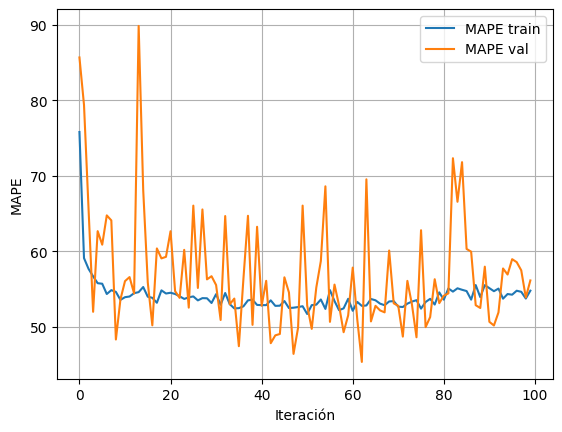

In [124]:
plt.plot(historia.history['loss'],label='MAPE train')
plt.plot(historia.history['val_loss'],label='MAPE val')
plt.xlabel('Iteración')
plt.ylabel('MAPE')
plt.grid('True')
plt.legend()

In [126]:
# Cálculo de rmses para train, val y test
MAPE_tr = model.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
MAPE_vl = model.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
MAPE_ts = model.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  MSE train:\t {MAPE_tr}')
print(f'  MSE val:\t  {MAPE_vl}')
print(f'  MSE test:\t {MAPE_ts}')

Comparativo desempeños:
  MSE train:	 [58.72498321533203, 0.1034502238035202, 58.727806091308594, 0.02139192819595337]
  MSE val:	  [56.133419036865234, 0.12950848042964935, 56.16807174682617, 0.03352585434913635]
  MSE test:	 [56.18436050415039, 0.10774971544742584, 56.1724739074707, 0.023191489279270172]


In [129]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)
    
    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    y_pred_s = model.predict(x,verbose=0)
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

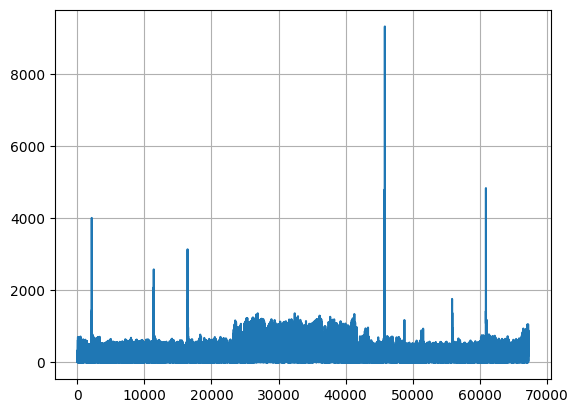

In [131]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = np.abs(y_ts.flatten()-y_ts_pred.flatten())
minimo = np.min(errores)
maximo = np.max(errores)
error_promedio = np.mean(errores)
plt.plot(errores);
plt.grid('True')

In [132]:
print(f'El error máximo fue {maximo}')
print(f'El error mínimo fue {minimo}')
print(f'El error máximo fue {error_promedio}')

El error máximo fue 9326.4677734375
El error mínimo fue 0.00048828125
El error máximo fue 208.11870886003572


In [174]:
with mlflow.start_run(run_id="0517d53b709d4c2e90ce80f413f4fede") as run:
    mlflow.log_artifact('loss_curves.png')
    mlflow.log_artifact('error_curves.png')

#### En general, no se obtuvieron buenos resultados. Para un futuro, se recomienda probar redes con arquitecturas más complejas.

In [175]:
mlflow.end_run()